In [41]:
import torch
from torchvision import datasets,transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [76]:
valid_size=0.15
#transform-combine
transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5,),(0.5,))
        ])
#download the dataset
train=datasets.MNIST(root='./data1',download=True,train=True,transform=transform)
test=datasets.MNIST(root='./data1',download=True,train=False,transform=transform)

#create a validation set
indices=list(range(len(train)))
np.random.shuffle(indices)
split=int(np.floor(valid_size*len(train)))
train_idx,valid_idx=indices[split:],indices[:split]

#subsampler
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)
#load the dataset
trainset=torch.utils.data.DataLoader(train,batch_size=64,sampler=train_sampler)
validset=torch.utils.data.DataLoader(train,batch_size=64,sampler=valid_sampler)
testset=torch.utils.data.DataLoader(test,batch_size=64,shuffle=False)

51008

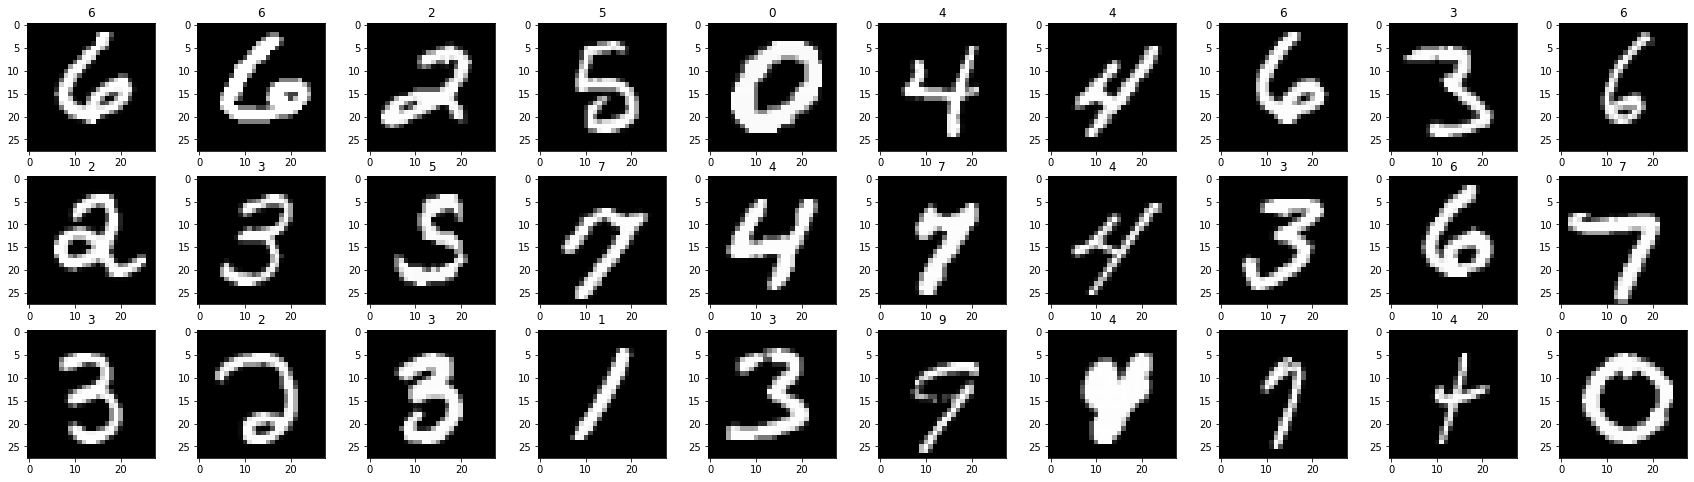

In [55]:
#visualize data along with labels
images,labels=next(iter(trainset))
images=images.numpy()
# plot the images in the batch, along with the corresponding labels
#1.create a figure object
#create axis object and add subplot
#3.imshow(784 dim)
fig=plt.figure(figsize=(30,8))
for idx in np.arange(30):
    ax=fig.add_subplot(3,30/3,idx+1)
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title(str((labels[idx]).item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


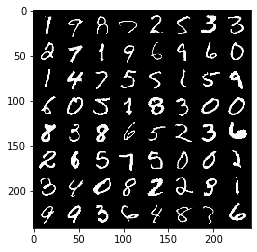

In [3]:
#visualze 64 batch grid
def imgshow(image): 
    make_grid=torchvision.utils.make_grid(image)
    plt.imshow(make_grid.permute(1,2,0))
dataiter=iter(trainset)
images,labels=next(dataiter)
imgshow(images)

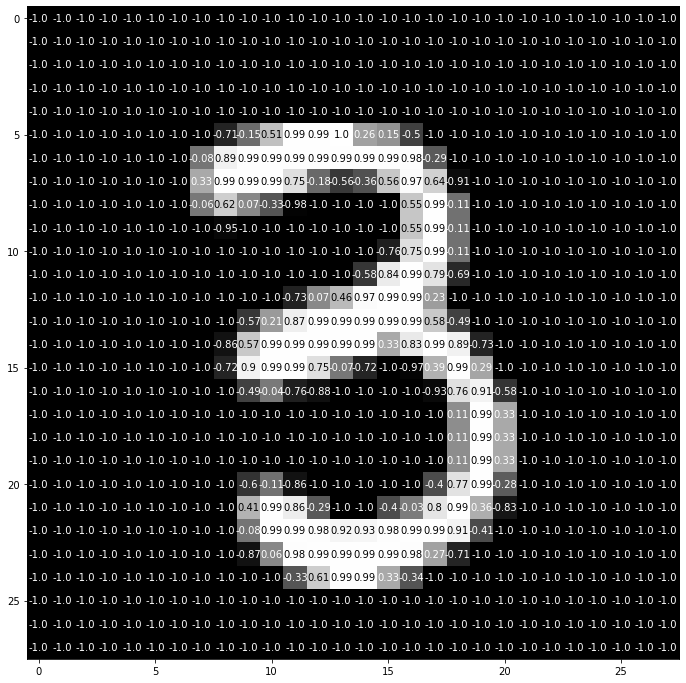

In [83]:
img = np.squeeze(images[20])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2)
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


In [85]:
#Network Architecture with nn.Functional
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
        self.dropout=nn.Dropout(p=0.2)
    def forward(self,x):
        x=x.view(x.shape[0],-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.log_softmax(self.fc4(x),1)
        return x

net=Network()
optimizer=optim.Adam(net.parameters(),lr=0.01)
criterion=nn.NLLLoss()
epocs=50
train_losses, valid_losses = [], []
min_test_loss=np.Inf
for i in range(epocs):
    training_loss=0
    for images,labels in trainset:
        optimizer.zero_grad()
        #feedforward
        ps=net.forward(images)
        #loss
        loss=criterion(ps,labels)
        #backprop
        loss.backward()
        #update
        optimizer.step()
        training_loss+=loss.item()
    else:
        accuracy=0
        valid_loss=0
        with torch.no_grad():
            #turn off dropout
            for images,labels in validset:
                log_ps=net(images)
                ps=torch.exp(log_ps)
                #predicted class and original lable-getting accuracy
                top_p,top_c=ps.topk(1,dim=1)
                valid_loss+=criterion(log_ps,labels).item()
                equals=top_c==labels.view(*top_c.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(training_loss/len(trainset))
        valid_losses.append(valid_loss/len(validset))
        
        print(f"valid accuracy={accuracy/len(validset)}")
        print(f'training loss:{training_loss/len(trainset)}')
        
        if(valid_loss<min_test_loss):
            print(f'valid loss is {valid_loss/len(validset)}')
            print("saving model")
            torch.save(net.state_dict(),'mnist.pth')
            min_test_loss=valid_loss   

valid accuracy=0.921409547328949
training loss:0.4404890505851736
valid loss is 0.2768011100008978
saving model
valid accuracy=0.9312278628349304
training loss:0.26605460390102686
valid loss is 0.26253534467719125
saving model
valid accuracy=0.9337100982666016
training loss:0.24489212830035645
valid loss is 0.25740827197301475
saving model
valid accuracy=0.9460992217063904
training loss:0.22369788146321867
valid loss is 0.2204146034592855
saving model
valid accuracy=0.9429077506065369
training loss:0.21669915124745934
valid accuracy=0.9435727000236511
training loss:0.2143414005510967
valid accuracy=0.9482935070991516
training loss:0.19492310635661392
valid loss is 0.21329103597829527
saving model
valid accuracy=0.9422428607940674
training loss:0.18579014035004893
valid accuracy=0.9328235387802124
training loss:0.19748554846045177
valid accuracy=0.9429963827133179
training loss:0.1819060052233226
valid accuracy=0.9525044560432434
training loss:0.1802477746868303
valid loss is 0.20089715

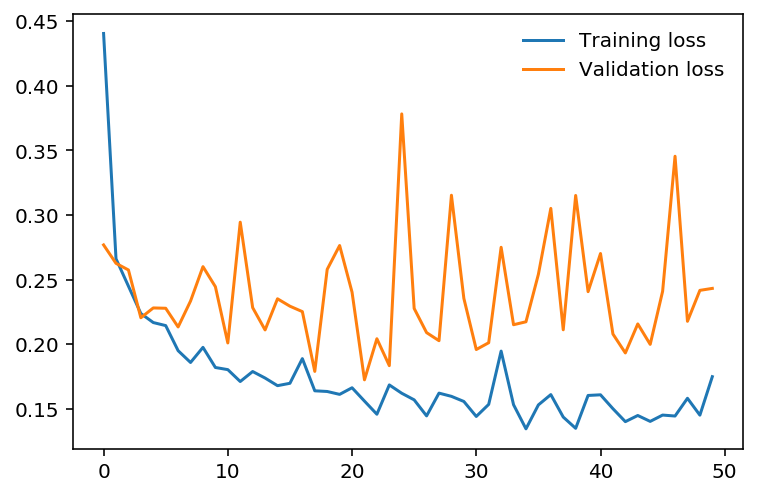

In [87]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [119]:
#save the model
total_parameters=sum(p.numel() for p in net.parameters())
torch.save(net.state_dict(),'mnist.pth')
#load the model
model=Network()
load=torch.load('mnist.pth')
model.load_state_dict(load)
print(total_parameters)

242762


In [90]:
model=Network()
load=torch.load('mnist.pth')
model.load_state_dict(load)
correct=0
total=0
with torch.no_grad():
    for images,labels in testset:
        #forward
        log_scores=model.forward(images)
        scores=torch.exp(log_scores)
        top_p,top_c=scores.topk(1,dim=1)
        correct+=(top_c==labels.view(*top_c.shape)).sum().item()
        total+=labels.size()[0]
print(f'accuracy is {correct/total}')

accuracy is 0.9605


In [91]:
#accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for images,labels in testset:
        log_scores=model.forward(images)
        scores=torch.exp(log_scores)
        top_p,top_c=scores.topk(1,dim=1)
        correct=(top_c==labels.view(*top_c.shape))
        for i in range(4):     
            label=labels[i]
            class_total[label]+=1
            class_correct[label]+=correct[i].item()

In [92]:
for i in range(10):
    print(f'Accuracy of digit {i} is {100*(class_correct[i]/class_total[i])}')

Accuracy of digit 0 is 98.46153846153847
Accuracy of digit 1 is 97.26027397260275
Accuracy of digit 2 is 94.02985074626866
Accuracy of digit 3 is 95.23809523809523
Accuracy of digit 4 is 97.05882352941177
Accuracy of digit 5 is 92.5
Accuracy of digit 6 is 96.42857142857143
Accuracy of digit 7 is 94.91525423728814
Accuracy of digit 8 is 95.0
Accuracy of digit 9 is 93.5064935064935


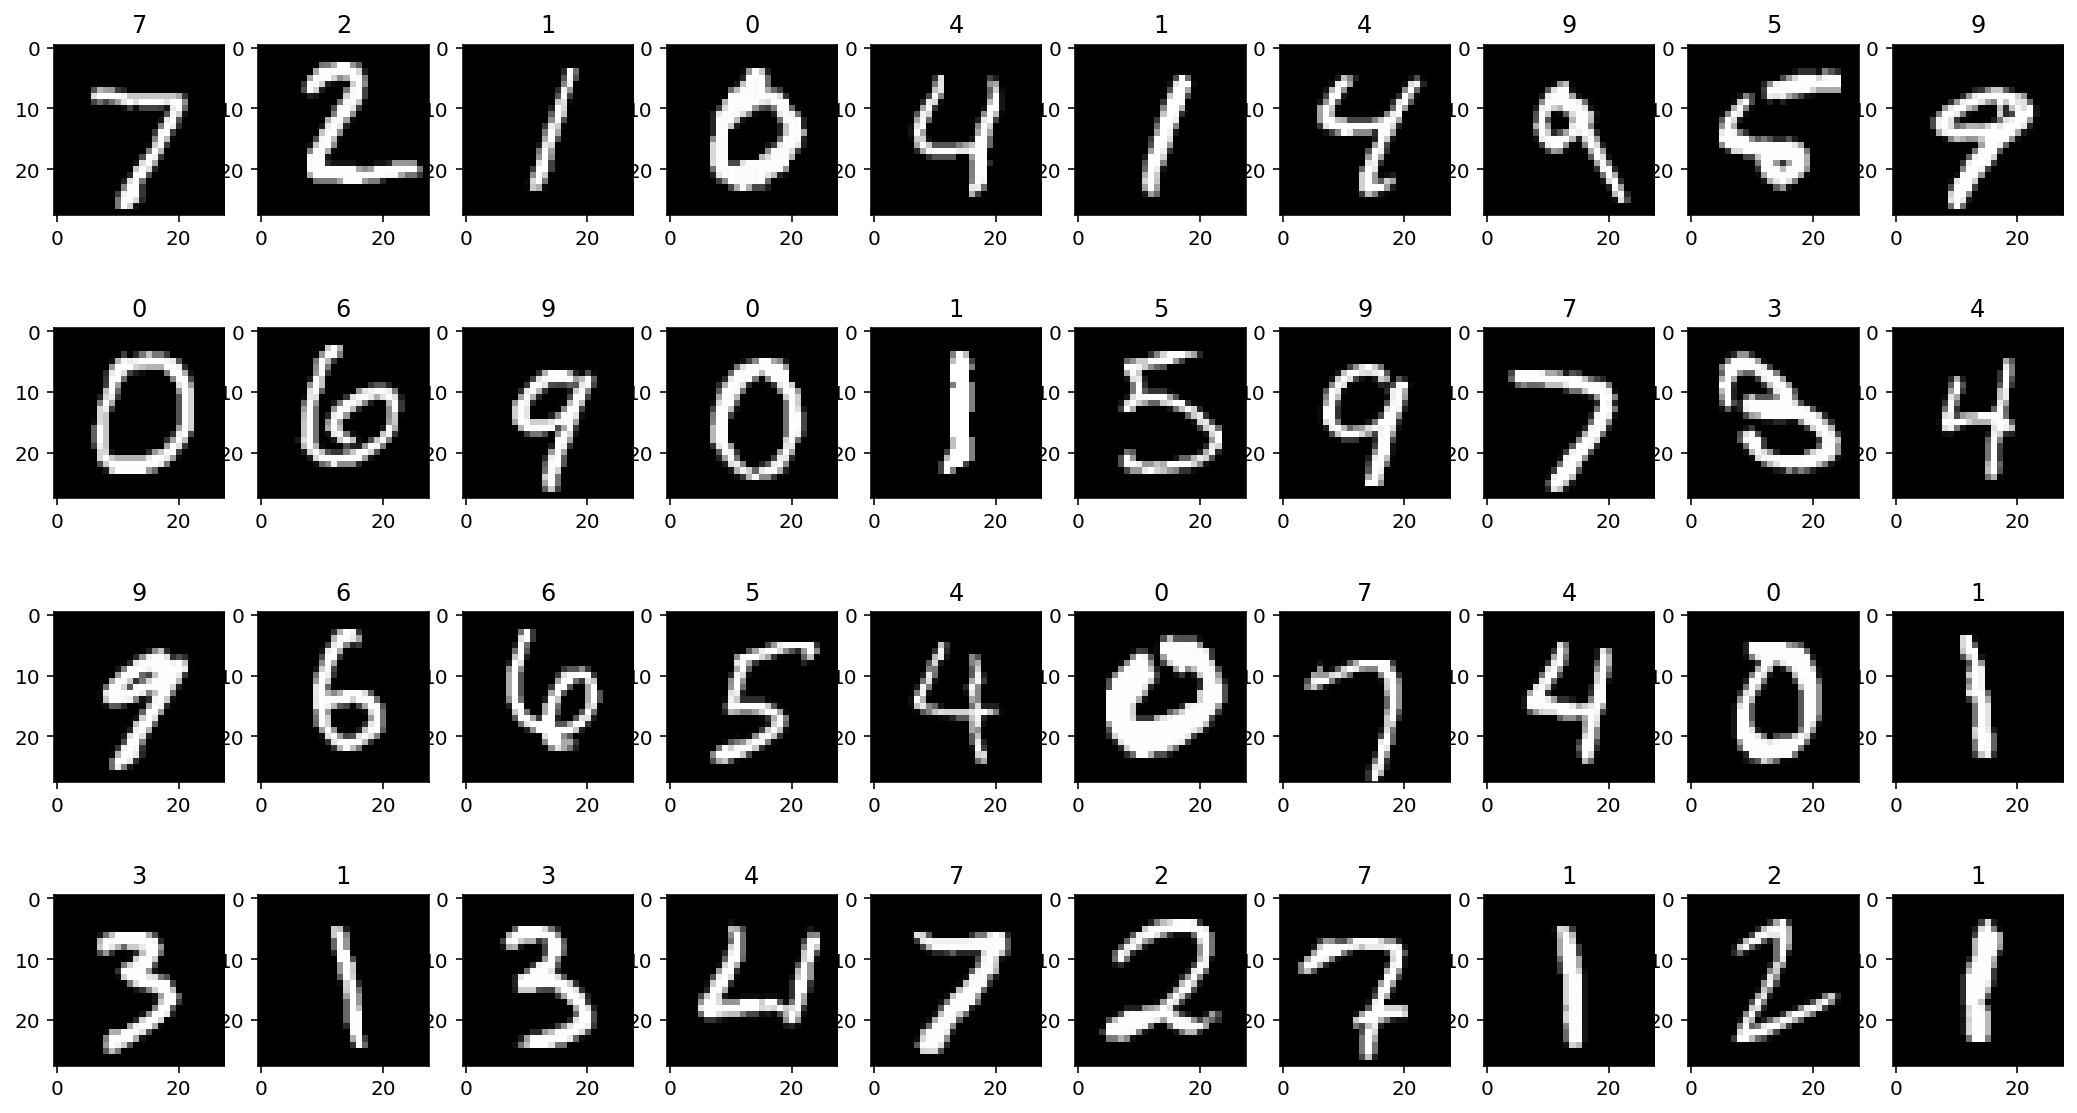

In [93]:
with torch.no_grad():
    images,labels=next(iter(testset))
    log_scores=model.forward(images)
    scores=torch.exp(log_scores)
    top_p,top_c=scores.topk(1,dim=1)
    correct=(top_c==labels.view(*top_c.shape))
#fig ob
fig=plt.figure(figsize=(18,10))
#ax object

for idx in range(40):
    ax=fig.add_subplot(4,40/4,idx+1)
    ax.imshow(images[idx].squeeze(),cmap='gray')
    ax.set_title(str(top_c[idx].item()))